In [1]:
import os, sys, glob, shutil
import subprocess

import mdtraj as md
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import math

from IPython.display import Image, display
%matplotlib inline
nmer = 5
mpl.rcParams.update({'font.size': 16})

In [6]:
%pwd

'/Users/suvince/git/peptoid_24summer/peptoid/19AE1-4-A/GAFF/protonated/HREX_500ns'

In [3]:
# Loop through each directory in the current working directory
# to create grofiles containing *just* the peptoid coordinates

for state_dir in os.listdir('.'):
    if os.path.isdir(state_dir) and state_dir.startswith('state_'):
        input_gro = os.path.join(state_dir, 'HREMD.part0001.gro')
        output_gro = os.path.join(state_dir, 'HREMD_withoutwater.part0001.gro')
        command = f'echo "24\nq\n" | gmx editconf -f {input_gro} -n index.ndx -o {output_gro}'
        
        # Run the command
        try:
            subprocess.run(command, shell=True, check=True)
            print(f"Processed {input_gro}")
        except subprocess.CalledProcessError as e:
            print(f"Failed to process {input_gro}: {e}")


Processed state_3/HREMD.part0001.gro
Processed state_4/HREMD.part0001.gro
Processed state_5/HREMD.part0001.gro
Processed state_2/HREMD.part0001.gro
Processed state_0/HREMD.part0001.gro
Processed state_1/HREMD.part0001.gro


In [4]:
# Define the directory path
directory = "omega_data/"

# Check if the directory exists
if os.path.exists(directory):
    # Remove all contents of the directory
    shutil.rmtree(directory)
    # Recreate the empty directory
    os.makedirs(directory)
    print(f"All contents in '{directory}' have been cleared.")
else:
    # Create the directory if it does not exist
    os.makedirs(directory)
    print(f"Directory '{directory}' did not exist, so it has been created.")


Directory 'omega_data/' did not exist, so it has been created.


In [10]:
# Define omega dihedral indices, gromcas start from 1, while np start from 0
omega_dihedral_indices = np.array([
    [  4,   5,  18,  27],
    [ 27,  28,  41,  45],
    [ 45,  46,  57,  66],
])

# Ensure the omega_data directory exists
omega_path = 'omega_data/'
if not os.path.exists(omega_path):
    os.makedirs(omega_path)

# Calculate omegas for each state
nstates = 6
for state in range(nstates):
    xtcfile = f"state_{state}/HREMD.part0001.xtc"
    grofile = f"state_{state}/HREMD_withoutwater.part0001.gro"
    traj = md.load(xtcfile, top=grofile)
    omegas = md.compute_dihedrals(traj, omega_dihedral_indices) * (180.0 / math.pi)

    # Save omegas
    outfile = os.path.join(omega_path, f"omegas_state{state}.npy")
    np.save(outfile, omegas)
    print(f"Saved omegas for state {state} to {outfile}")

/Users/suvince/anaconda3/lib/python3.8/site-packages/mdtraj/formats/gro.py:307: UserWarning: WARNING: two consecutive residues with same number (NPE, NAE)
  warnings.warn("WARNING: two consecutive residues with same number (%s, %s)" % (thisresname, residue.name))
/Users/suvince/anaconda3/lib/python3.8/site-packages/mdtraj/formats/gro.py:307: UserWarning: WARNING: two consecutive residues with same number (NAE, NPE)
  warnings.warn("WARNING: two consecutive residues with same number (%s, %s)" % (thisresname, residue.name))
/Users/suvince/anaconda3/lib/python3.8/site-packages/mdtraj/formats/gro.py:307: UserWarning: WARNING: two consecutive residues with same number (NHE, NPE)
  warnings.warn("WARNING: two consecutive residues with same number (%s, %s)" % (thisresname, residue.name))


Saved omegas for state 0 to omega_data/omegas_state0.npy
Saved omegas for state 1 to omega_data/omegas_state1.npy
Saved omegas for state 2 to omega_data/omegas_state2.npy
Saved omegas for state 3 to omega_data/omegas_state3.npy
Saved omegas for state 4 to omega_data/omegas_state4.npy
Saved omegas for state 5 to omega_data/omegas_state5.npy


### What is the time interval between `*.xtc` snapshots?

In [9]:
%cat prod_fep.mdp | grep nstxout-compressed

nstxout-compressed      = 5000      ; save compressed coordinates every 10.0 ps


In [11]:
dt_in_ns = 0.010   #  ns

### What are the dimensions of the omega-angle arrays?

In [12]:
for i in range(nstates):
    omegas = np.load(f"omega_data/omegas_state{i}.npy")
    print(f'state {i}:, {omegas.shape}')

state 0:, (50001, 3)
state 1:, (50001, 3)
state 2:, (50001, 3)
state 3:, (50001, 3)
state 4:, (50001, 3)
state 5:, (50001, 3)


In [53]:
current_state = [0, 1, 2, 3, 4, 5]
logfile = 'state_0/HREMD.part0001.log'
pattern = 'Repl ex'
output_file = 'state0_log.dat'

states = []
states.append( current_state.copy() ) # Make a copy of initial_state

# DEbug:  Let's see if xtc is written BEFORE swap 
states.append( current_state.copy() ) # Make a copy of initial_state

VERBOSE = False

try:

    with open(logfile, 'r') as file:
        lines = file.readlines()

        for line in lines:
            if pattern in line:
                parts = line.strip().split()
                if VERBOSE:
                    print(f'parts: {parts}')
                for i in range(2, len(parts)):
                    if 'x' in parts[i]:
                        index1 = int(parts[i-1])
                        index2 = int(parts[i+1])
                        
                        # Swap the positions in the current state
                        tmp1, tmp2 = current_state[index1], current_state[index2]
                        current_state[index1] = tmp2
                        current_state[index2] = tmp1
                states.append( current_state.copy() )  # Append a copy of the last state
    
    # DEbug:  Let's see if xtc is written BEFORE swap 
    if (0):
        # for the last frame
        states.append( current_state.copy() )  # Append a copy of the state (last frame doesn't swap)

                
    # Write states to output_file
    with open(output_file, 'w') as outfile:
        for state in states:
            outfile.write(' '.join(map(str, state)) + '\n')

    print(f"Output saved to {output_file}")


except FileNotFoundError:
    print(f"The file {logfile} does not exist.")
except Exception as e:
    print(f"An error occurred: {e}")



Output saved to state0_log.dat
state


In [50]:
# Load in the omega values for all replicas
all_omegas = []
for state in range(6):  # Adjust the range to include all replicas
    all_omegas.append(np.load(f"omega_data/omegas_state{state}.npy"))
all_omegas = np.array(all_omegas)  # (nreps, nsnaps, nresidues)
print('all_omegas.shape', all_omegas.shape)
#print(all_omegas[:5])

# Arrange each snapshot by replica (not temp)
replica_indices = np.loadtxt('state0_log.dat')
print("replica_indices.shape", replica_indices.shape)
print(replica_indices)

all_omegas_by_replica = np.zeros(all_omegas.shape)

start = 0
nsnaps = 50001
nreps = 6
for i in range(nsnaps):
    Ind = np.argsort(replica_indices[i, :])
    all_omegas_by_replica[:, i, :] = all_omegas[Ind, i, :]

# Save the data for each state once
for rep in range(nreps):
    np.save(f"omega_data/omegas_rep{rep}.npy", all_omegas_by_replica[rep, :, :])
    print(f"Saved omegas for replica {rep} to omega_data/omegas_rep{rep}.npy")
    #print(np.load(f'omega_data/omegas_rep{rep}.npy')[:5])

all_omegas.shape (6, 50001, 3)
replica_indices.shape (50001, 6)
[[0. 1. 2. 3. 4. 5.]
 [0. 1. 2. 3. 4. 5.]
 [1. 0. 3. 2. 5. 4.]
 ...
 [3. 2. 0. 4. 1. 5.]
 [3. 0. 2. 1. 4. 5.]
 [0. 3. 1. 2. 5. 4.]]
Saved omegas for replica 0 to omega_data/omegas_rep0.npy
Saved omegas for replica 1 to omega_data/omegas_rep1.npy
Saved omegas for replica 2 to omega_data/omegas_rep2.npy
Saved omegas for replica 3 to omega_data/omegas_rep3.npy
Saved omegas for replica 4 to omega_data/omegas_rep4.npy
Saved omegas for replica 5 to omega_data/omegas_rep5.npy


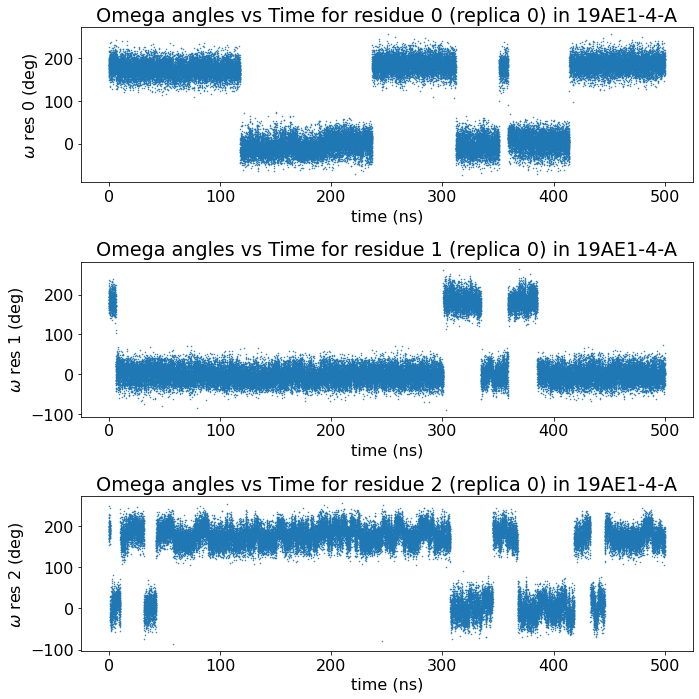

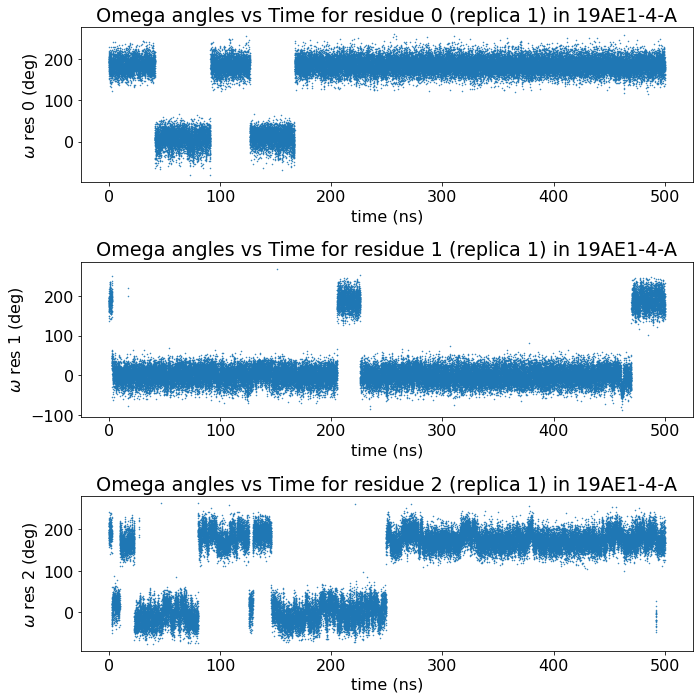

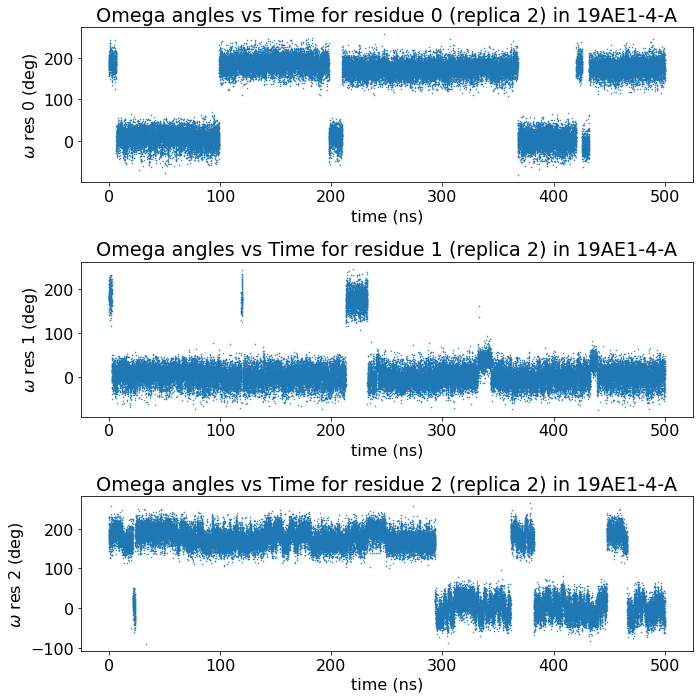

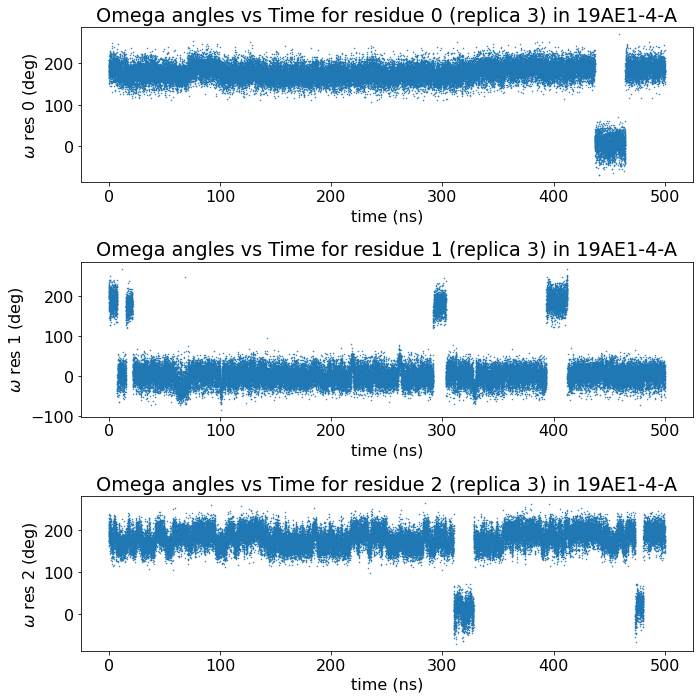

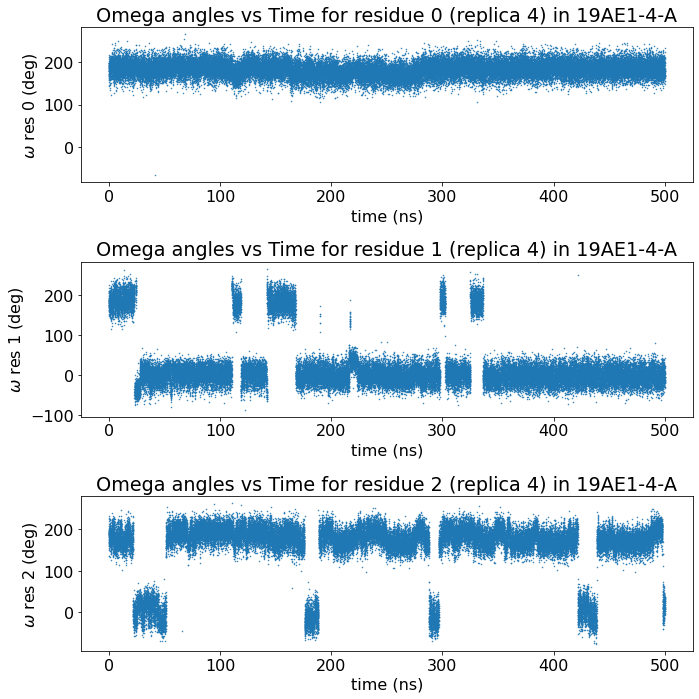

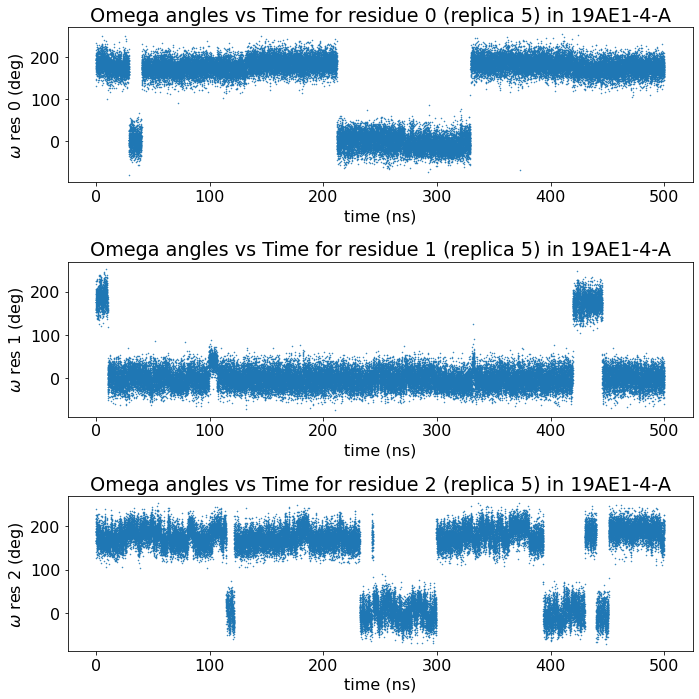

In [60]:
# Adjust omega values into the range (-90, 270)
all_omegas_by_replica = (all_omegas_by_replica + 90.0) % 360.0 - 90.0

start = 0
nsnaps = 50001
nreps = 6
residues_to_plot = [0, 1, 2]
num_residues = len(residues_to_plot)

ShowPlots = True

# Plot omega angles vs time for selected residues for each replica
for i in range(nreps):
    plt.figure(figsize=(10, 10))
    for panel, residue in enumerate(residues_to_plot, 1):
        plt.subplot(num_residues, 1, panel)
        t = np.arange(start, nsnaps) * 0.010  # Time axis in ns
        plt.plot(t, all_omegas_by_replica[i, start:nsnaps, residue], '.', ms=1)
        plt.xlabel('time (ns)')
        plt.ylabel(f'$\\omega$ res {residue} (deg)')
        plt.title(f'Omega angles vs Time for residue {residue} (replica {i}) in 19AE1-4-A')
    plt.tight_layout()
    if ShowPlots:
        plt.show()
    else:
        outfilename = f'omega_data/Omega_angles_vs_Time_residue_{residue}_Replica_{i}_in_19AE1-4-A.png'
        plt.savefig(outfilename)
        print(f"Saved at: {outfilename}")
        plt.clf()  # Clear the figure for the next set of plots

In [30]:
# Plot omega angles vs time for selected residues for each replica
for residue in residues_to_plot:
    plt.figure(figsize=(10, 10))
    for i in range(nreps):
        plt.subplot(nreps, 1, i + 1)
        t = np.arange(start, nsnaps) * 0.010  # Time axis in ns
        plt.plot(t, all_omegas[i, start:nsnaps, residue])
        plt.xlabel('time (ns)')
        plt.ylabel(f'$\\omega$ res {residue} (deg)')
        plt.title(f'Omega angles vs Time for residue {residue} (Replica {i}) in 19AE1-4-A')
    plt.tight_layout()
    plt.savefig(f'omega_data/Omega_angles_vs_Time_for_residue_{residue}_in_19AE1-4-A.png')
    print(f"Saved at: omega_data/Omega_angles_vs_Time_for_residue_{residue}_in_19AE1-4-A.png")
    plt.clf()  # Clear the figure for the next set of plots

Saved at: omega_data/Omega_angles_vs_Time_for_residue_0_in_19AE1-4-A.png
Saved at: omega_data/Omega_angles_vs_Time_for_residue_1_in_19AE1-4-A.png
Saved at: omega_data/Omega_angles_vs_Time_for_residue_2_in_19AE1-4-A.png


<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

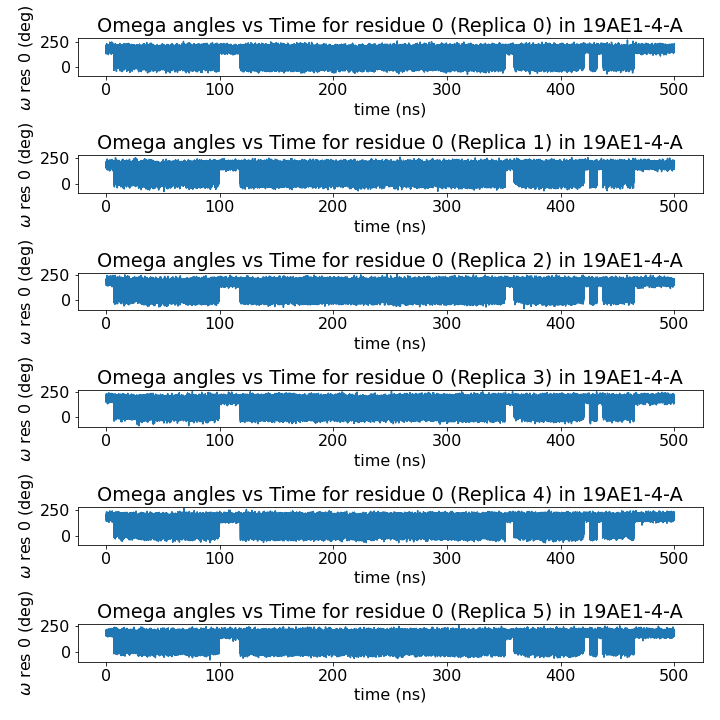

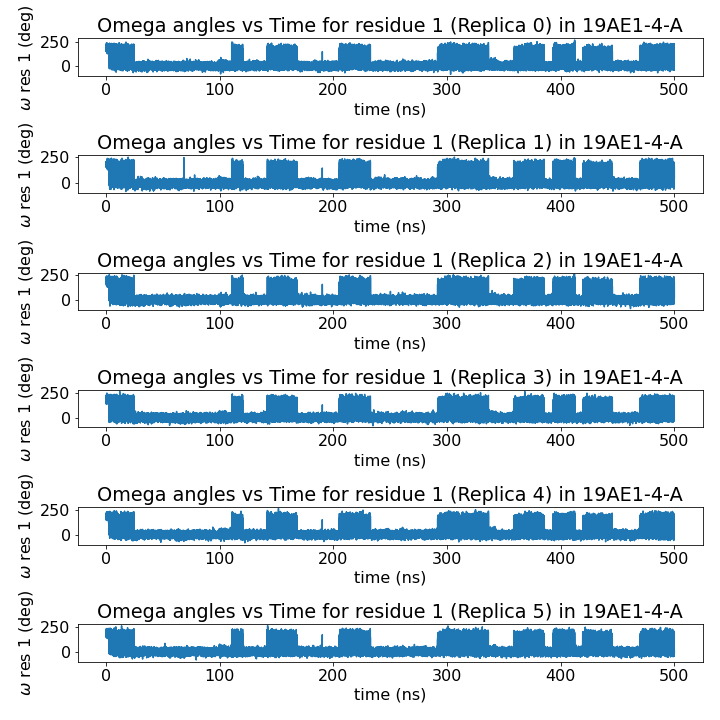

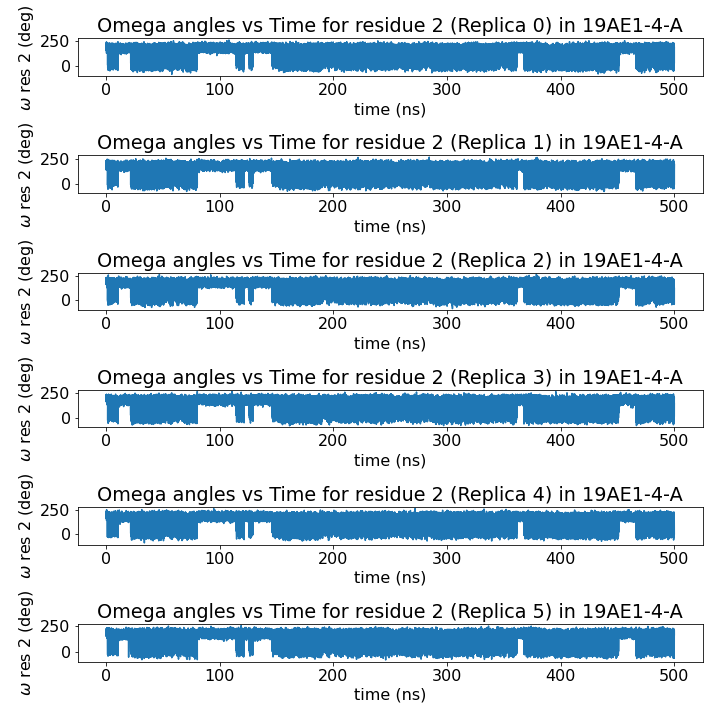

In [31]:
for i in range(3):
    display(Image(f'omega_data/Omega_angles_vs_Time_for_residue_{i}_in_19AE1-4-A.png'))

In [59]:
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Load the omegas data
omegas = np.load('omega_data/omegas_rep0.npy')
#print(omegas[:10])
print(omegas.shape)

wcss = [] # within-cluster sum of squares
for i in range(1, 100):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(omegas)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 100), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()


(50001, 3)


KeyboardInterrupt: 

In [ ]:
optimal_clusters = 8  
kmeans = KMeans(n_clusters=optimal_clusters, random_state=0)
kmeans.fit(omegas)

cluster_labels = kmeans.labels_
# Count the number of data points in each cluster
unique_labels, counts = np.unique(cluster_labels, return_counts=True)

# Create a DataFrame for better formatting
cluster_info = pd.DataFrame({'Cluster': unique_labels, 'Count': counts})

# Print the cluster info
print(cluster_info)

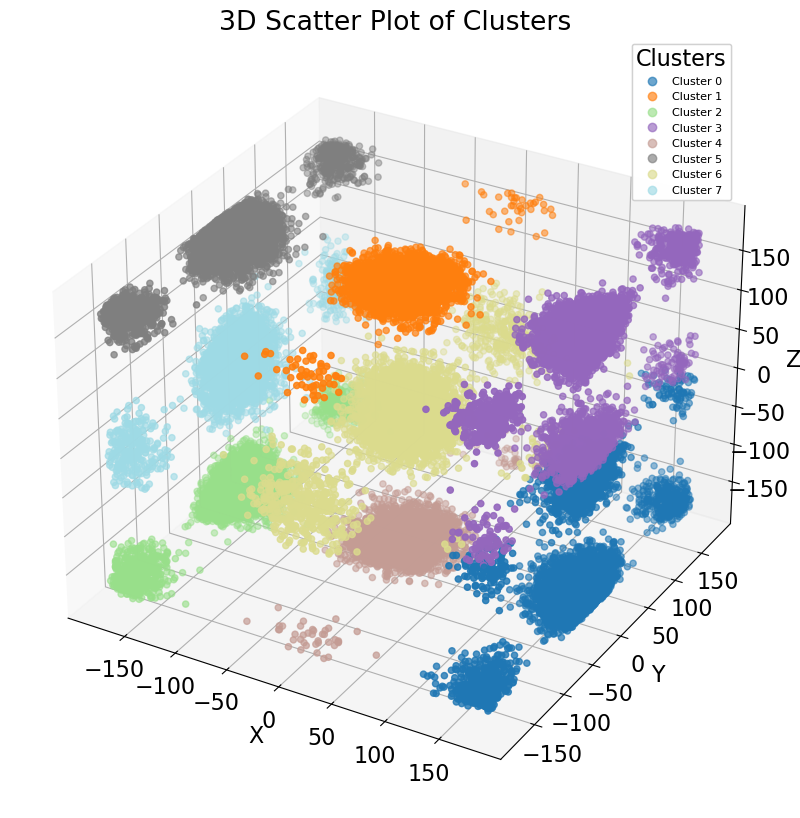

In [111]:
from mpl_toolkits.mplot3d import Axes3D

# 3D Scatter plot of clusters
fig = plt.figure(figsize=(16, 10))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(omegas[:, 0], omegas[:, 1], omegas[:, 2], c=cluster_labels, cmap='tab20')  # Use 'tab20' colormap for distinct colors

ax.set_title('3D Scatter Plot of Clusters')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Create a legend and place it in the upper right corner
handles, labels = scatter.legend_elements(prop="colors", alpha=0.6)
# Format the labels correctly without conversion
legend1 = ax.legend(handles, [f"Cluster {i}" for i in range(optimal_clusters)], title="Clusters", loc="upper left", bbox_to_anchor=(0.8, 1), prop={'size': 8})
ax.add_artist(legend1)

plt.show()

In [ ]:
# Initialize KMeans estimator
estimator = KMeans(
    n_clusters=3,  # number of clusters
    init_strategy='uniform',  # uniform initialization strategy
    max_iter=0,  # don't actually perform the optimization, just place centers
    fixed_seed=13,
    n_jobs=8,
    progress=tqdm
)

# Perform clustering
clustering = estimator.fit(omegas).fetch_model()
assignments = clustering.transform(omegas)

# Plot the results
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
f.suptitle('Cluster centers and assignments directly after uniform initialization')

# Assuming 'samples' variable refers to the same data as 'omegas'
ax1.hexbin(*(omegas.T), bins='log')
ax1.scatter(*(clustering.cluster_centers.T), marker='o', c='m')
ax1.axis('off')
ax1.set_title('cluster centers')

ax2.scatter(*(omegas[::10].T), c=assignments[::10])
ax2.axis('off')
ax2.set_title('assignments of data to centers')

plt.show()

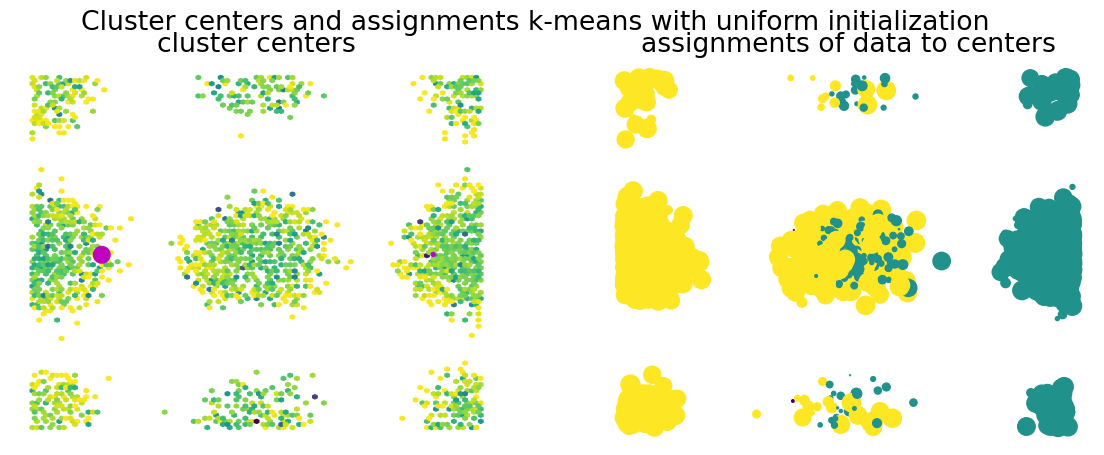

In [66]:
# Set initial centers and increase max iterations for the new clustering
estimator.initial_centers = clustering.cluster_centers
estimator.max_iter = 5000

# Perform new clustering with extended iterations
clustering_new = estimator.fit(omegas).fetch_model()

# Plot the new clustering results
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
f.suptitle('Cluster centers and assignments k-means with uniform initialization')

ax1.hexbin(*(omegas.T), bins='log')
ax1.scatter(*(clustering_new.cluster_centers.T), marker='o', c='m')
ax1.axis('off')
ax1.set_title('cluster centers')

ax2.scatter(*(omegas[::10].T), c=clustering_new.transform(omegas)[::10])
ax2.axis('off')
ax2.set_title('assignments of data to centers')

plt.show()

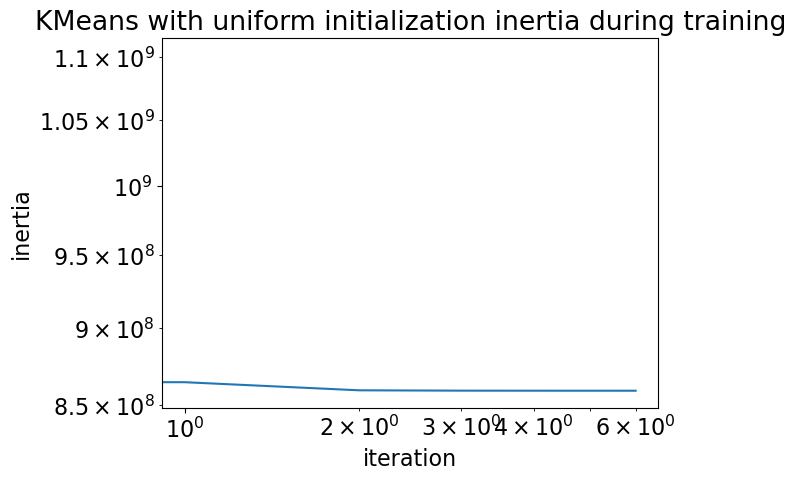

In [67]:
plt.loglog(clustering_new.inertias)
plt.xlabel("iteration")
plt.ylabel("inertia")
plt.title("KMeans with uniform initialization inertia during training");


In [50]:
def autocorr(x):
    tau = x.size
    mu = x.mean()
    g = np.correlate(x, x, mode='full')[tau-1:]
    n = np.arange(tau,0,-1)
    return g/n

avg_autocorrel = [] 
for residue in range(3):
    all_autocorrel = []
    for replica in range(6):
        # Example calculation, replace with your actual calculation
        cis_trans = np.where(all_omegas[replica,:,residue] > 90.0, 1.0, 0.0)
        print(f"residue {residue}, replica {replica}, cis_trans: {cis_trans}")
        
        all_autocorrel.append(autocorr(cis_trans))
    
    avg_autocorrel.append(np.array(all_autocorrel).mean(axis=0))
    outfile = f'omega_data/omega_autocorrel_residue{residue}.npy'
    print(f"Saving {outfile} ...")
    np.save(outfile, avg_autocorrel[-1])

residue 0, replica 0, cis_trans: [1. 1. 1. ... 1. 1. 1.]
residue 0, replica 1, cis_trans: [1. 1. 1. ... 1. 1. 1.]
residue 0, replica 2, cis_trans: [1. 1. 1. ... 1. 1. 1.]
residue 0, replica 3, cis_trans: [1. 1. 1. ... 1. 1. 1.]
residue 0, replica 4, cis_trans: [1. 1. 1. ... 1. 1. 1.]
residue 0, replica 5, cis_trans: [1. 1. 1. ... 1. 1. 1.]
Saving omega_data/omega_autocorrel_residue0.npy ...
residue 1, replica 0, cis_trans: [1. 1. 1. ... 0. 0. 0.]
residue 1, replica 1, cis_trans: [1. 1. 1. ... 0. 0. 0.]
residue 1, replica 2, cis_trans: [1. 1. 1. ... 0. 1. 1.]
residue 1, replica 3, cis_trans: [1. 1. 1. ... 0. 0. 0.]
residue 1, replica 4, cis_trans: [1. 1. 1. ... 1. 0. 0.]
residue 1, replica 5, cis_trans: [1. 1. 1. ... 0. 0. 0.]
Saving omega_data/omega_autocorrel_residue1.npy ...
residue 2, replica 0, cis_trans: [1. 1. 1. ... 0. 1. 1.]
residue 2, replica 1, cis_trans: [1. 1. 1. ... 0. 0. 1.]
residue 2, replica 2, cis_trans: [1. 1. 1. ... 1. 1. 1.]
residue 2, replica 3, cis_trans: [1. 1. 1

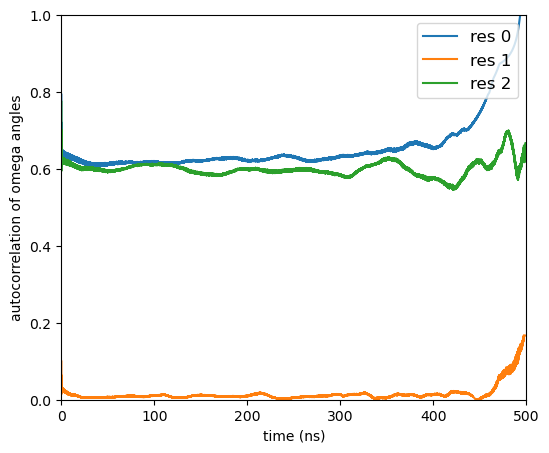

In [59]:
avg_autocorrels = []
plt.figure(figsize=(6,5))
t = np.arange(0, len(cis_trans))*0.010 # frames saved every 10 ps
for residue in range(0,3):   # the last residue
    infile = f'omega_data/omega_autocorrel_residue{residue}.npy'
    data = np.load(infile)
    avg_autocorrels.append(data)
    plt.plot(t, data, label='res %d'%residue)
    plt.xlim(0,500) # only show first part of the autocorrelation curves
    plt.ylim(0,1) # only show first part of the autocorrelation curves

plt.xlabel('time (ns)')
plt.ylabel('autocorrelation of omega angles')
plt.legend(loc='upper right', fontsize=12)

plt.show()

--- Residue 0 ---
### FIT to a0 + a1*exp(-(x/tau)) ###
Best-fit a0: 2418.6627622578876 +/- 60782549.7822274
Best-fit a1: -2418.053665976392 +/- 60782548.45237565
Best-fit tau: 25188017.61440144 +/- 6595370791135485.0
--- Residue 1 ---
### FIT to a0 + a1*exp(-(x/tau)) ###
Best-fit a0: 0.009277281218308776 +/- 2.9515010009115426e-10
Best-fit a1: 0.022205999841184217 +/- 7.945805113942268e-08
Best-fit tau: 5.593403864232853 +/- 0.010386384458443504
--- Residue 2 ---
### FIT to a0 + a1*exp(-(x/tau)) ###
Best-fit a0: 0.5960737287035115 +/- 7.062554788992503e-09
Best-fit a1: 0.015258450694692963 +/- 8.307482889099114e-08
Best-fit tau: 58.17409459854052 +/- 4.007122975685978


/var/folders/2g/yfyfpy7d3n3fwl_23ytkftvm0000gn/T/ipykernel_63571/23797525.py:7: RuntimeWarning: overflow encountered in exp
  return a0 + a1 * np.exp(-x / tau)


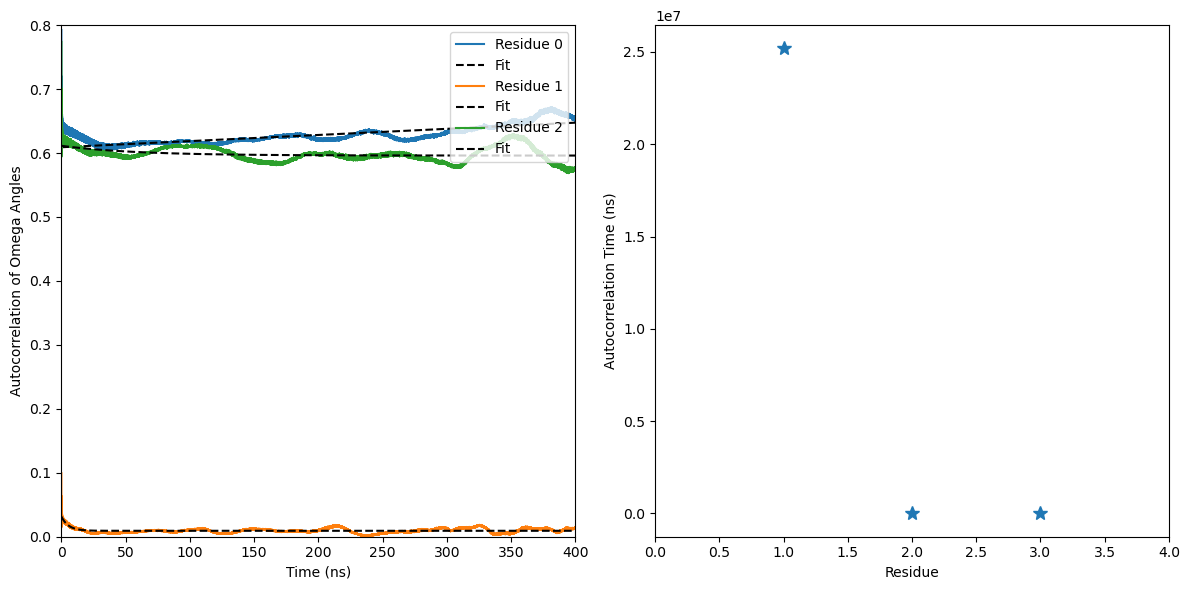

In [62]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Functional form for fitting
def single_exp_decay(x, a0, a1, tau):
    return a0 + a1 * np.exp(-x / tau)

# Fit each autocorrelation and plot results
fit_taus = []

plt.figure(figsize=(12, 6))

# Loop over each residue
for residue in range(3):
    
    # Initial guess for fitting parameters
    first_value = avg_autocorrels[residue][0]
    initial_guess = [first_value / 2.0, first_value / 2.0, 40.0]  # Initial guess [a0, a1, tau]
    
    # Perform curve fitting
    popt, pcov = curve_fit(single_exp_decay, t[:40000], avg_autocorrels[residue][:40000], p0=initial_guess)
    
    # Compute fitted curve
    y_fit = single_exp_decay(t[:40000], *popt)
    
    # Collect fitted tau values
    fit_taus.append(popt[2])
    
    # Print fit results
    print(f'--- Residue {residue} ---')
    print('### FIT to a0 + a1*exp(-(x/tau)) ###')
    print(f'Best-fit a0: {popt[0]} +/- {pcov[0][0]}')
    print(f'Best-fit a1: {popt[1]} +/- {pcov[1][1]}')
    print(f'Best-fit tau: {popt[2]} +/- {pcov[2][2]}')

    # Plot original data and fitted curve
    plt.subplot(1, 2, 1)
    plt.plot(t[:40000], avg_autocorrels[residue][:40000], label=f'Residue {residue}')
    plt.plot(t[:40000], y_fit, 'k--', label='Fit')
    plt.xlim(0, 400)
    plt.ylim(0, 0.8)
    plt.xlabel('Time (ns)')
    plt.ylabel('Autocorrelation of Omega Angles')
    plt.legend(loc='upper right', fontsize=10)
    
# Plotting the fitted tau values
plt.subplot(1, 2, 2)
plt.plot(range(1, 4), fit_taus, '*', markersize=10)
plt.xlim(0, 4)
plt.xlabel('Residue')
plt.ylabel('Autocorrelation Time (ns)')
plt.tight_layout()

plt.show()
